# Strategy backtesting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as s

In [2]:
dfd = pd.read_csv("../data/dip-test.csv")
dfp = pd.read_csv("../data/peak-test.csv")
X_ft = pd.read_csv("../data/xft-dip-test.csv")
df = pd.read_csv("../data/ft-dip-test.csv")

In [3]:
len(df)

100000

In [87]:
def transact(close:float, width:float, buy:bool):
    """buys"""
    global btc
    global amt
    global busd
    global bl
    global sl
    global transaction
    global cooldown
    global bc
    global sc
    global binr
    global sinr
    btc += amt/bl if buy else -amt/sl
    busd -= amt*1.002 if buy else -amt*0.998
    bl = transact_price(bl, width, buy, binr+max(20*btc/(btc+busd)-10, 0)) if buy else bl
    sl = sl if buy else transact_price(sl, width, buy, sinr+max(20*busd/(btc+busd)-10, 0))
    transaction = close if buy else -close
    if buy:
        bc += cooldown
        binr += 1
        sinr = 2   ### Change this to ###
    else:
        sc += cooldown
        binr = 2
        sinr += 1
    
def transact_price(close:float, width:float, buy:bool, c:float):
    """creates the new transaction price"""
    return (1.-((width+c)/100.))*close if buy else (1.+((width+c)/400.))*close
def bitcoin_value(close:float):
    """returns the current value of bitcoins"""
    global btc
    return btc*close

In [88]:
btc = 0.
busd = 100.
amt = 10. #Amount of money per each buy and sell
bl = None #buying limit
sl = None #selling limit
cooldown = 120 #Cooldown limit
bc = 0 #buying cooldown
sc = 0 #selling cooldown
plot = [] #[None, 30848.32, None]
total = [] #Total transactions
acc = [] #accumulated wealth: busd + btc in USD
transaction = None
usd = []
blimit = [] # For plotting
slimit = []
binr = 2 #Buys in a row
sinr = 2 #sells in a row

initiate = False

In [89]:
for i in range(len(dfd)):
    transaction = None
    initiate = False
    close = df.iloc[i].close
    high = df.iloc[i].high
    low = df.iloc[i].low
    width = X_ft.iloc[i].volatility_dc_wband_10
    if bl and low<=bl and busd>=amt and bc==0:                                  #limit buy order
        transact(close, width, True)
    elif sl and high>=sl and bitcoin_value(high)>=amt and sc==0:                                #limit sell order
        transact(close, width, False)
    elif dfd.iloc[i].target == 1 and busd>=amt and bc==0: #Machine says buy
#         sl = None
        tp = transact_price(close, width, True, binr)
        if not bl: # or tp<bl
            bl = tp
        initiate = True
    elif dfp.iloc[i].target == 1 and bitcoin_value(close)>=amt and sc==0: #Machine says buy
#         bl = None
        tp = transact_price(close, width, False, sinr)
        if not sl: # or tp>sl
            sl = tp
        initiate = True
    plot.append(transaction)
    if transaction is not None:
#         print(f"t: {transaction}, btc = {round(btc, 5)}, busd = {busd}, bc = {bc}, sc = {sc}, bl = {round(bl, 5) if bl is not None else None}, sl = {round(sl, 5) if sl is not None else None}, time = {i}")
        total.append(transaction)
    if not initiate:
        sl = sl-(sl-close)*0.0002 if sl != None else sl ### Change this to 0.0007 ###
        bl = bl+(close-bl)*0.0002 if bl != None else bl
    acc.append(busd + bitcoin_value(close))
    usd.append(busd)
    bc -= 1 if bc > 0 else 0
    sc -= 1 if sc > 0 else 0
    blimit.append(bl)
    slimit.append(sl)


In [90]:
acc[-1]

87.91599623325367

In [91]:
len(total)

37

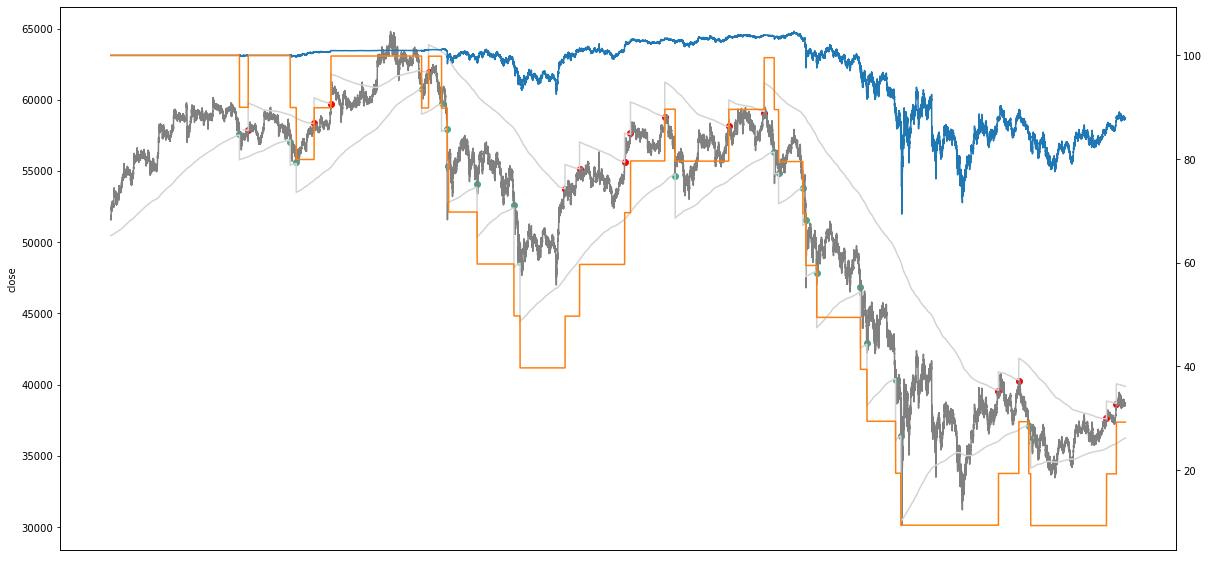

In [92]:
a = 0
b = 100000
fig,ax = plt.subplots(figsize=(20, 10))



plot_buy = list(map(lambda x: None if x == None or x<0 else x, plot[a:b]))
plot_sell = list(map(lambda x: None if x == None or x>0 else -x, plot[a:b]))

# ax.plot(acc[a:b])

# ax1 = ax.twiny()

ax.scatter(range(b-a), 
            plot_buy,
            color="#43aa8b")

ax.scatter(range(b-a), 
            plot_sell,
            color="red")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(
        list(dfd.close)[a:b],
        color="gray")

ax1 = ax.twinx()
ax1.plot(acc[a:b])
ax1.plot(usd[a:b])
ax.plot(blimit[a:b], color="lightgray")
ax.plot(slimit[a:b], color="lightgray")




ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

In [27]:
X_ft.columns

Index(['volume_nvi_o_close_rate_50', 'mom_srsi_10_d', 'bb',
       'volatility_dc_wband_10', 'volatility_bb_pband_100',
       'volatility_bb_wband_200', 'trend_trix_20_log', 'trend_vi_50_amp',
       'mom_rsi_30', 'volume_cmf_50_rate_200',
       'trend_sma_200_diff_o_close_log', 'mom_ppo_30_hist',
       'trend_sma_50_diff_log'],
      dtype='object')

In [93]:
a = [1, 2, 3]
a[-1]

3